# **Róbert Šafár** & **Matúš Totcimak**
## 3. fáza: *Strojové učenie*
#### Dataset 82
#### Podiel práce 50:50
#
#

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score

pd.set_option('display.max_columns', None)

## Načítanie CSV súborov

In [2]:
con = pd.read_csv("dataset82/connections.csv", sep='\t')
proc = pd.read_csv("dataset82/processes.csv", sep='\t')

## Vstupné dáta v tejto fáze sú 'raw' dáta, preto vykonáme potrebné predspracovanie dát rovnako ako vo fáze 2.

### Pred spojením `Connections` a `Processes` odstránime duplikátne záznamy.

In [3]:
con = con.loc[~con.duplicated()].reset_index(drop=True).copy()
proc = proc.loc[~proc.duplicated()].reset_index(drop=True).copy()

### Spojenie `Connections` a `Processes`.

In [4]:
df = pd.merge(con, proc, on=['ts', 'imei', 'mwra'])

### Overenie chýbajúcich hodnôt. Z `EDA` už vieme, že žiadne nie sú.

In [5]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

### Vymažeme atribút `imei`, pretože ho nepovažujeme za atribút, ktorý by určoval hodnotu `mwra`. Je to len identifikátor zariadení. Takisto aj `ts`.

In [6]:
df = df.drop(columns=['ts', 'imei'])

In [7]:
class OutlierDetection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.original_columns = X.columns.tolist()
        self.thresholds_ = {}
        for col in X.columns:
            if col == 'c.updateassist' or col == 'mwra':
                continue
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.thresholds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()

        X_transformed = X_transformed[X_transformed['c.updateassist'] <= 5]

        for col, (lower_bound, upper_bound) in self.thresholds_.items():
            if col == 'c.updateassist' or col == 'mwra':
                continue
            X_transformed[col] = np.where(X_transformed[col] < lower_bound, lower_bound, X_transformed[col])
            X_transformed[col] = np.where(X_transformed[col] > upper_bound, upper_bound, X_transformed[col])

        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.original_columns)

### *`Funckia:`* Zmena outlierov na hraničné hodnoty.

In [8]:
# def change_outliers_iqr(df, exceptions):
#     for column in df:
#         if column in exceptions:
#             continue
        
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
        
#         IQR = Q3 - Q1
        
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
#         df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
#     return df

### Zmena outlierov pre všetky atribúty `df` okrem `df['c.updateassist']`.

In [9]:
# df = change_outliers_iqr(df=df, exceptions=['c.updateassist', 'mwra'])

### Odstránenie záznamov, kde `df['c.updateassist'] >= 5`. Rovnako ako v `EDA`.

In [10]:
# lines_to_remove = df[df['c.updateassist'] > 5].index
# df = df.drop(lines_to_remove).copy()

#
### Aplikujeme Transformácie: `Yeo-Johnson`, na atribúty, ktoré sa podobajú na normálnu distribúciu a `Quantile`, na atribúty s uniformnou distribúciou, respektíve s nie-normálnou distribúciou, s cieľom získať normálne rozdelenie pre všetky atribúty.
### Aplikujeme Škálovanie: `MinMax` pre jednotné rozsahy všetkých atribútov.

In [13]:
yeo_johnson_columns = ['c.dogalize', 'c.android.chrome', 'c.katana', 'c.android.gm',
                       'c.android.youtube', 'c.android.vending',
                       'p.android.packageinstaller', 'p.android.externalstorage', 'p.system',
                       'p.android.settings', 'p.android.documentsui', 'p.android.gm', 'p.katana',
                       'p.google', 'p.android.gms', 'p.inputmethod.latin']

quantile_columns = ['c.updateassist', 'c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider', 'p.android.chrome', 'p.process.gapps',
                    'p.olauncher', 'p.browser.provider', 'p.notifier', 'p.gms.persistent',
                    'p.android.defcontainer', 'p.android.vending', 'p.simulator', 'p.dogalize']


transformer = ColumnTransformer(
    transformers=[
        ('yeo_johnson', PowerTransformer(method='yeo-johnson'), yeo_johnson_columns),
        ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), slice(0, 31))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipeline = Pipeline(
    steps=[
        ('outliers', OutlierDetection()),
        ('transformer', transformer),
        ('scaler', scaler)
    ]
)

transformed_data = pipeline.fit_transform(df)
df = pd.DataFrame(transformed_data, columns=pipeline.get_feature_names_out())


### `Funkcia:` Vykreslenie `KDE` grafov pre `DF`.

In [14]:
def show_kde_graphs(df, attributes):
    num_attributes = len(attributes)

    if num_attributes == 0:
        print("No attributes to show")
        return
    
    cols = min(5, num_attributes)
    rows = math.ceil(num_attributes / cols)
    
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, column in enumerate(attributes):
        plt.subplot(rows, cols, i + 1)
        sns.kdeplot(df[column], fill=True, color='blue', alpha=0.5)
        plt.title(column)
        plt.xlabel('Hodnoty')
        plt.ylabel('Hustota')

    plt.tight_layout()
    plt.show()

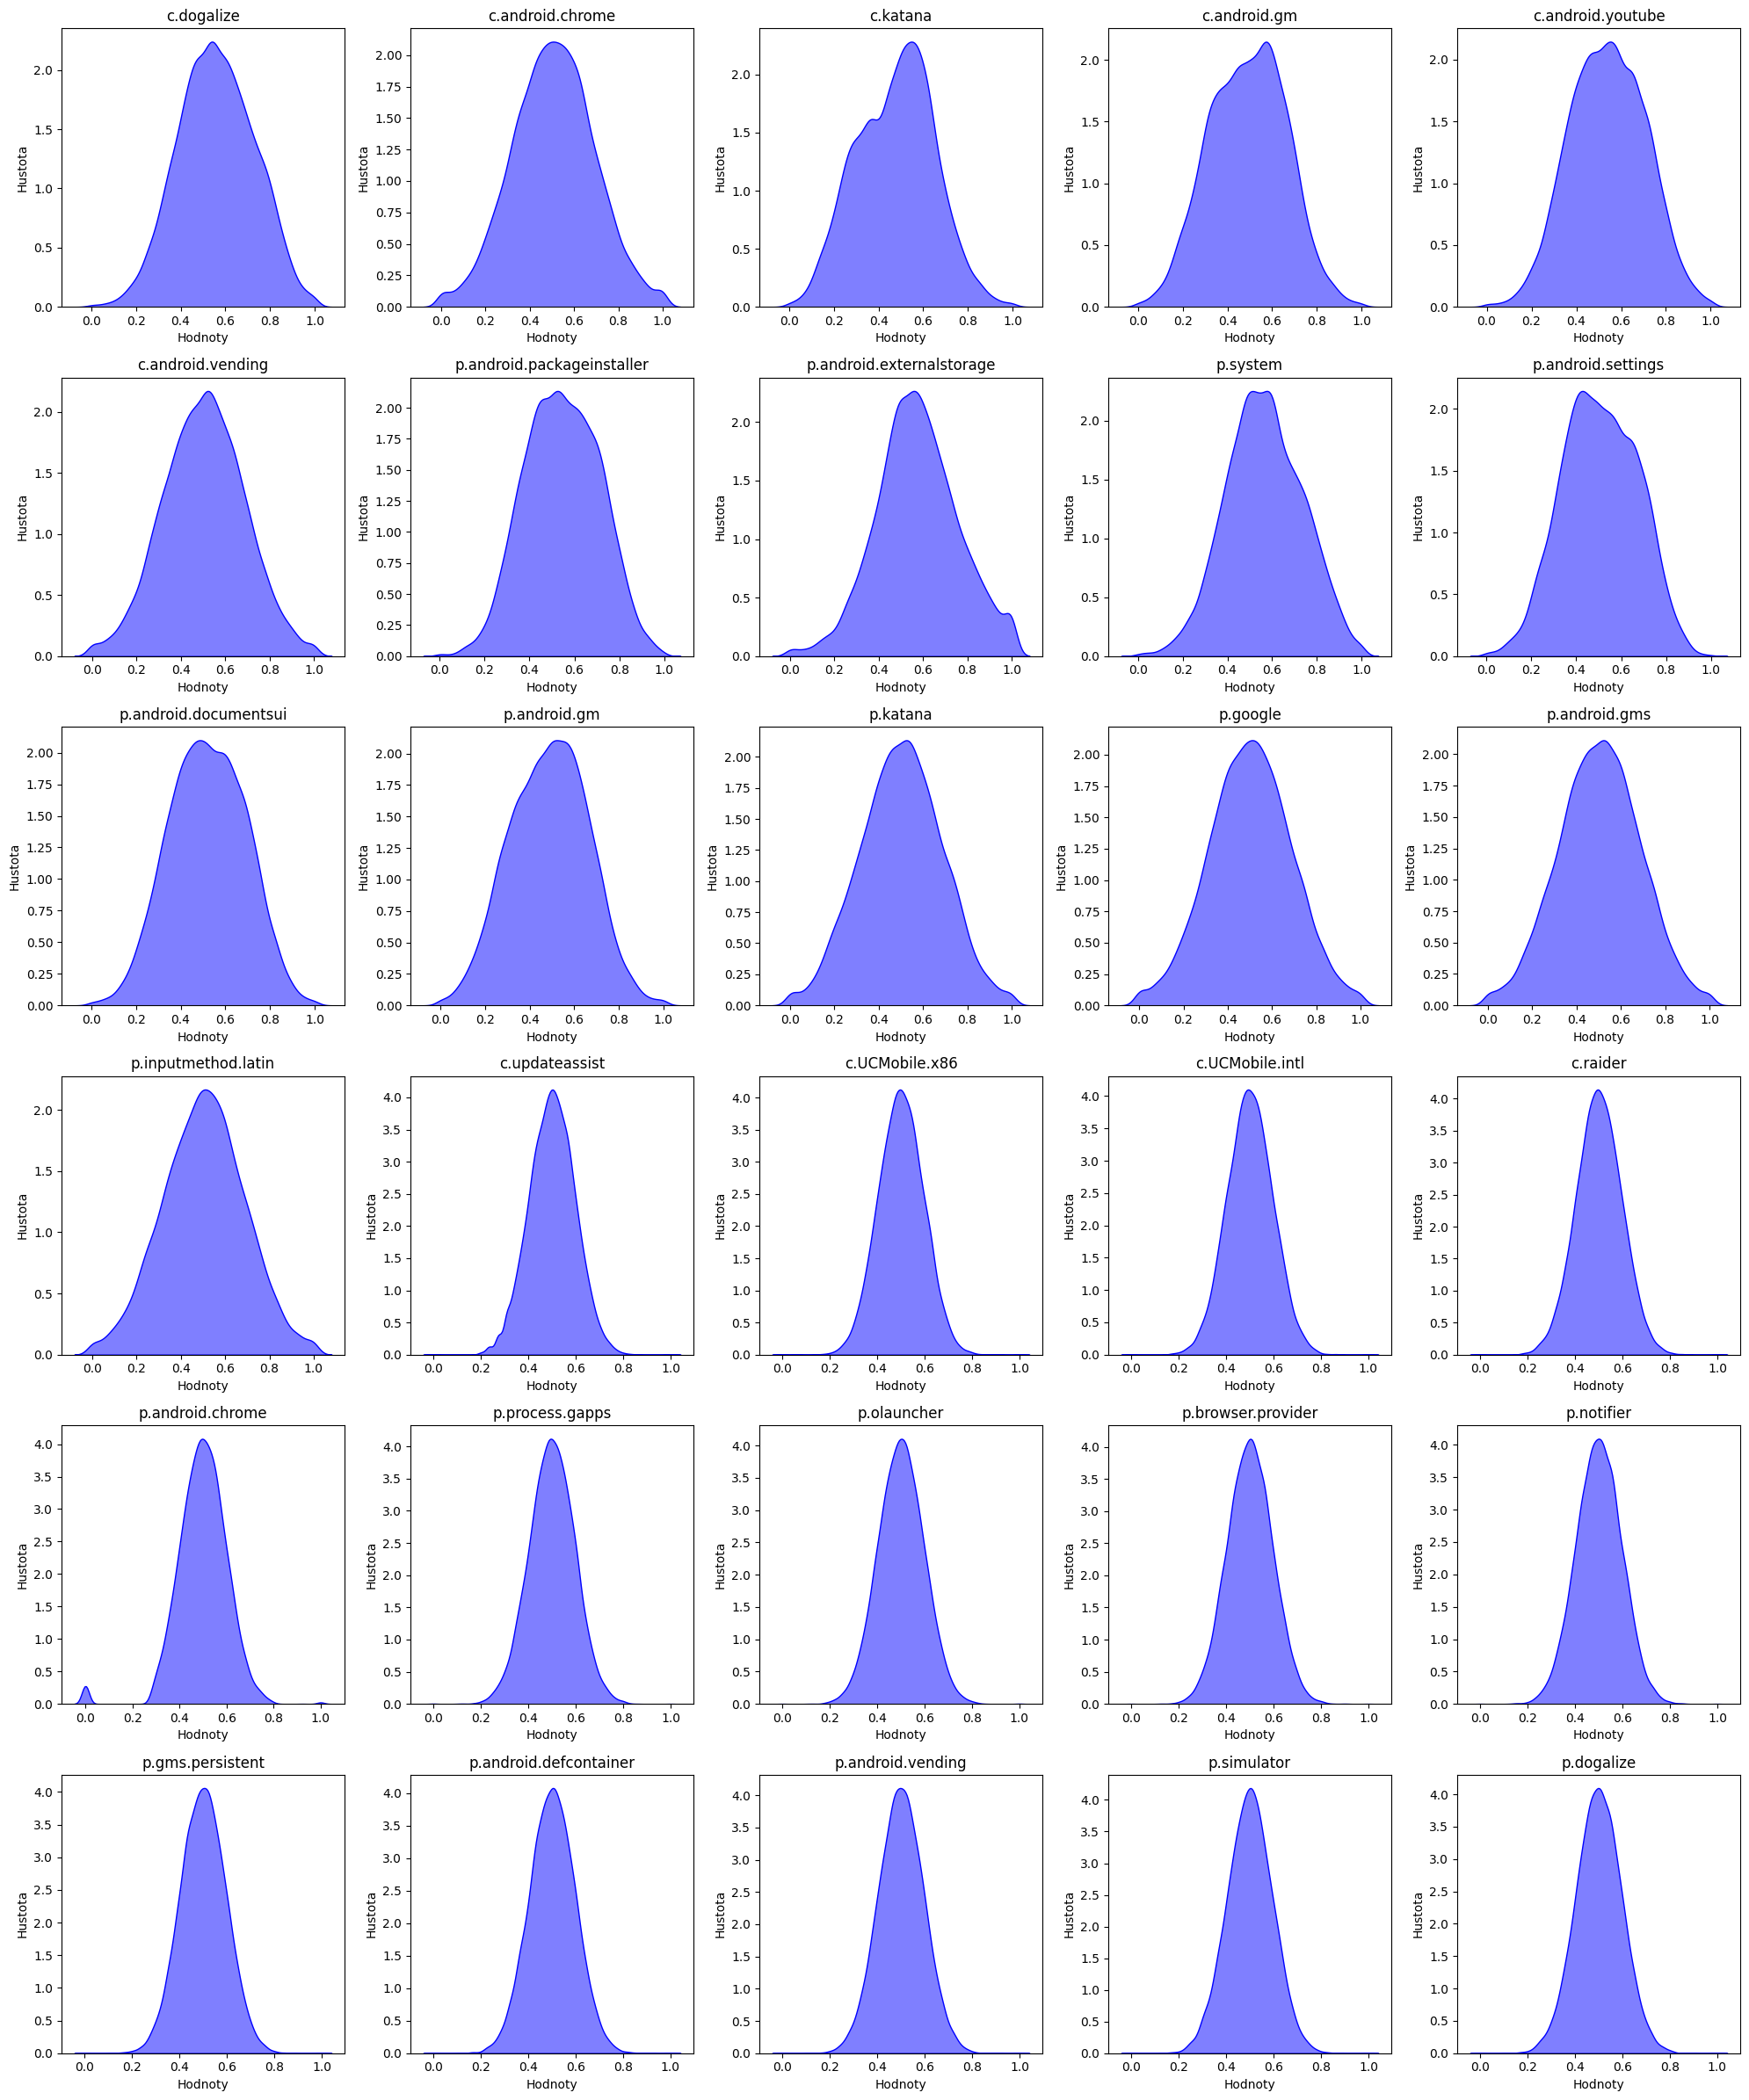

In [15]:
show_kde_graphs(df=df, attributes=df.drop(columns="mwra").columns)

### Môžeme vidieť, že najmä `Quantile` transformácia veľmi pomohla k normálemu rozdeleniu atribútov s predtým hlavne uniformnou distribúciou.

#
### DataFrame rozdelíme na `data` a `target`.

In [16]:
# Data
X = df.drop(columns=['mwra'])

# Target
y = df[['mwra']]

### Na výber najlepších `features` použijeme metódu `ANNOVA`, na základe fázy 2.

In [17]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit_transform(X, y.values.ravel())
names = X.columns[selector.get_support()]
X = X[names]
X.shape

(14961, 10)

### Pomer rozdelenia ponecháme `80:20` ako vo fáze 2.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

In [19]:
# show_kde_graphs(df=X_train, attributes=X_train.columns)

In [20]:
# show_kde_graphs(df=X_test, attributes=X_test.columns)

#
# **3.1 Jednoduchý klasifikátor na základe závislosti v dátach**

#
## *A) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň).*

In [21]:
from sklearn.tree import DecisionTreeClassifier
cld = DecisionTreeClassifier(criterion='entropy', max_depth=8)

#
## *B) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.*

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

Dtrain = cld.fit(X_train, y_train).predict(X_train)
Dtest = cld.fit(X_train, y_train).predict(X_test)

In [23]:
accuracy_score(y_test, Dtest)

0.8850651520213833

In [24]:
precision_score(y_test, Dtest)

0.8983488132094943

In [25]:
recall_score(y_test, Dtest)

0.9221398305084746

#
## *C) Zistite či Váš ID3 klasifikátor má overfit.*

In [26]:
print("ACCURACY")
print(accuracy_score(y_train, Dtrain))
print(accuracy_score(y_test, Dtest))
print()

print("PRECISION")
print(precision_score(y_train, Dtrain))
print(precision_score(y_test, Dtest))
print()

print("RECALL")
print(recall_score(y_train, Dtrain))
print(recall_score(y_test, Dtest))

ACCURACY
0.9205381016042781
0.8850651520213833

PRECISION
0.9243271356130542
0.8983488132094943

RECALL
0.9506552554158866
0.9221398305084746


#
# **3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia**

### `Funkcia:` Vypísanie metrík `accuracy`, `precision`, `recall` pre daný algoritmus.

In [27]:
def show_3_metrics(W_train, W_test, y_train, y_test):
    print("=== Model Evaluation Metrics ===\n")
    print(f"ACCURACY:")
    print(f"  Training: {accuracy_score(y_train, W_train):.4f}")
    print(f"  Testing : {accuracy_score(y_test, W_test):.4f}\n")

    print(f"PRECISION:")
    print(f"  Training: {precision_score(y_train, W_train):.4f}")
    print(f"  Testing : {precision_score(y_test, W_test):.4f}\n")

    print(f"RECALL:")
    print(f"  Training: {recall_score(y_train, W_train):.4f}")
    print(f"  Testing : {recall_score(y_test, W_test):.4f}")

#
## *A) Na trénovanie využite jeden stromový algoritmus v scikit-learn.*

### Rozhodli sme sa použiť `RandomForest` a ponechať defaultne nastavenia parametrov. Testovanie najlepších nastavení parametrov budeme realizovať v ďalľej časti.

In [28]:
clr = RandomForestClassifier()

Rtrain = clr.fit(X_train, y_train.values.ravel()).predict(X_train)
Rtest = clr.fit(X_train, y_train.values.ravel()).predict(X_test)

show_3_metrics(W_train=Rtrain, W_test=Rtest, y_train=y_train, y_test=y_test)

=== Model Evaluation Metrics ===

ACCURACY:
  Training: 1.0000
  Testing : 0.9098

PRECISION:
  Training: 1.0000
  Testing : 0.9187

RECALL:
  Training: 1.0000
  Testing : 0.9401


#
## *B) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.*

### Rozhodli sme sa použiť `k-Nearest Neighbors` a ponechať defaultne nastavenia parametrov. Testovanie najlepších nastavení parametrov budeme realizovať v ďalľej časti.

In [29]:
clk = KNeighborsClassifier()

Ktrain = clk.fit(X_train, y_train.values.ravel()).predict(X_train)
Ktest = clk.fit(X_train, y_train.values.ravel()).predict(X_test)

show_3_metrics(W_train=Ktrain, W_test=Ktest, y_train=y_train, y_test=y_test)

=== Model Evaluation Metrics ===

ACCURACY:
  Training: 0.9229
  Testing : 0.9105

PRECISION:
  Training: 0.9261
  Testing : 0.9180

RECALL:
  Training: 0.9525
  Testing : 0.9423


#
## *C) Porovnajte výsledky s ID3 z prvého kroku.*

#
## *D) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus.*

### Vizualizácia `RandomForest` nášho modelu s hĺbkou 2.

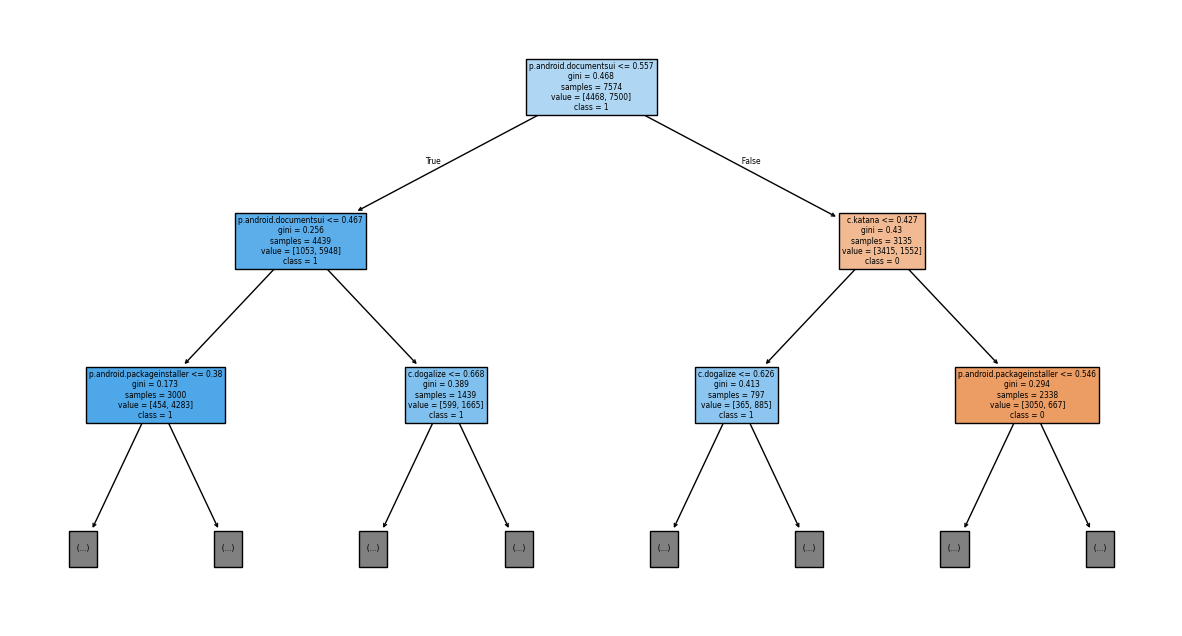

In [30]:
plt.figure(figsize=(15, 8))
plot_tree(clr.estimators_[0], feature_names=X.columns, class_names=['0', '1'], filled=True, max_depth=2)
plt.show()

### Vizualizácia `RandomForest` nášho modelu s maximálnou hĺbkou.

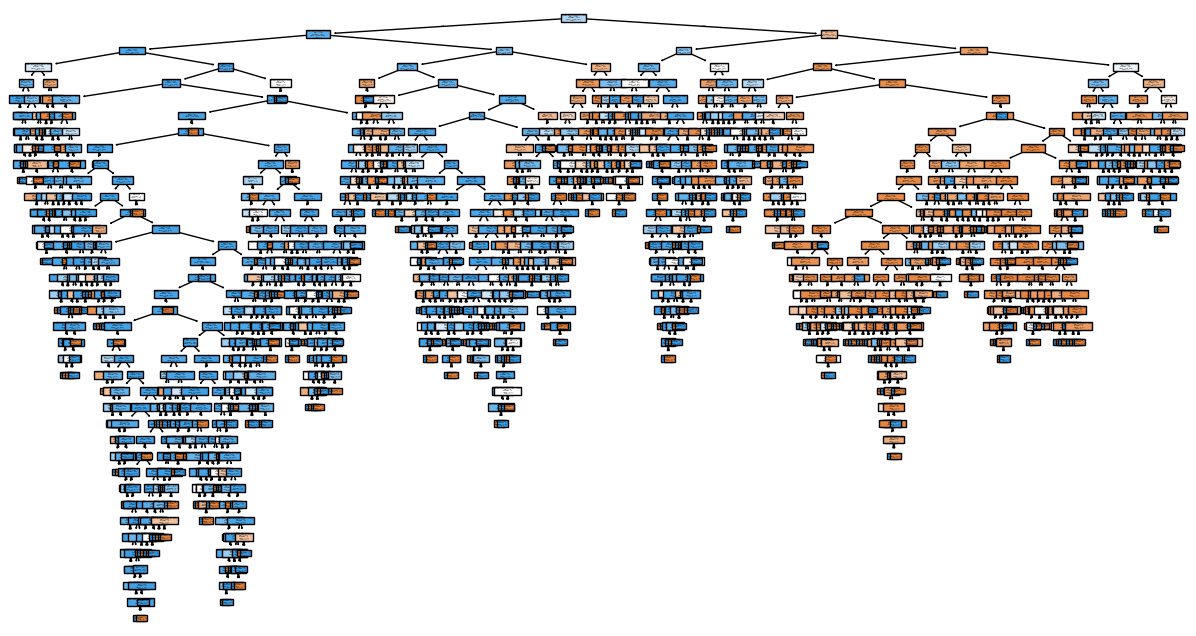

In [31]:
plt.figure(figsize=(15, 8))
plot_tree(clr.estimators_[0], feature_names=X.columns, class_names=['0', '1'], filled=True, max_depth=None)
plt.show()

#
## *E) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall.*

#
# **3.3 Optimalizácia alias hyperparameter tuning**

#
## *A) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).*

In [32]:
grid_param = {
    'n_estimators': [50, 100],
    'max_depth': [6, 8, 10, 12]
}

grid_search = GridSearchCV(estimator=clr, param_grid=grid_param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train.values.ravel())

print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Score:", grid_result.best_score_)

Best Parameters: {'max_depth': 12, 'n_estimators': 100}
Best Cross-Validation Score: 0.9159416510352354


#
## *B) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).*

In [33]:
bagging = BaggingClassifier(estimator=clr, n_estimators=10, random_state=42)
bagging.fit(X_train, y_train.values.ravel())
print(bagging.score(X_test, y_test))

0.9091212829936518


#
## *C) Využite krížovú validáciu (cross validation) na trénovacej množine.*

In [34]:
kfold = KFold()
cv_result = cross_val_score(estimator=clr, X=X_train, y=y_train.values.ravel(), cv=kfold, scoring='accuracy')

In [35]:
print(cv_result)
print(cv_result.mean())

[0.92439432 0.91478697 0.92314119 0.9134977  0.90806519]
0.9167770729232888


#
## *D) Dokážte že Váš nastavený najlepší model je bez overfitingu.*

#
# **3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu**

#
## *A) Stratégie riešenia chýbajúcich hodnôt a outlierov.*

#
## *B) Dátová transformácia (scaling, transformer, ...).*

#
## *C) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning.*

#
## *D) Ktorý model je Váš najlepší model pre nasadenie (deployment)?*

#
## *E) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?*